In [1]:
import os
import multiprocessing
from tqdm import tqdm_notebook as tqdm
import numpy as np
from scipy.ndimage import label
from skimage.transform import integral_image, resize
from skimage.feature import haar_like_feature, hessian_matrix, hessian_matrix_eigvals
from skimage.filters import threshold_otsu
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from phathom import io
from phathom.segmentation.segmentation import find_centroids
from phathom.utils import pmap_chunks, extract_box, insert_box

Using TensorFlow backend.


In [2]:
working_dir = '/media/jswaney/Drive/Justin/coregistration/gabi_pv'

In [3]:
pv_path = 'pvtdtomato_zarrstack/1_1_1'
syto_path = 'syto16_zarrstack/1_1_1'

pv_img = io.zarr.open(os.path.join(working_dir, pv_path))
syto_img = io.zarr.open(os.path.join(working_dir, syto_path))

pv_img.shape, syto_img.shape

((256, 7275, 5529), (256, 7275, 5529))

In [4]:
pv_slice = pv_img[0]
syto_slice = syto_img[0]

<IPython.core.display.Javascript object>


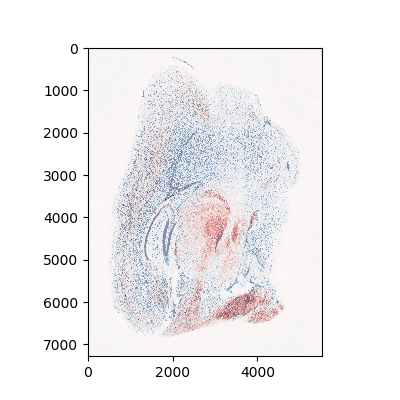

In [5]:
%matplotlib notebook
plt.figure(figsize=(4, 4))
plt.imshow(pv_slice, clim=[0, 1600], cmap='Reds')
plt.imshow(syto_slice, clim=[0, 3000], cmap='Blues', alpha=0.5)
plt.show()

In [6]:
sigma = 4.0

hessian = hessian_matrix(syto_slice, sigma)
eigvals = hessian_matrix_eigvals(hessian)

/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/feature/corner.py:167: UserWarning: deprecation warning: the default order of the hessian matrix values will be "row-column" instead of "xy" starting in skimage version 0.15. Use order="rc" or order="xy" to set this explicitly
  warn('deprecation warning: the default order of the hessian matrix values '


In [7]:
eigvals = np.clip(eigvals, None, 0)  # remove positive curvatures
threshold = -threshold_otsu(-eigvals[0])  # Based on larger eigenvalue
loc = np.where(eigvals[0] < threshold)
mask = np.zeros(syto_slice.shape, np.int)
mask[loc] = 1

In [8]:
lbl, nb_lbls = label(mask)
nb_lbls

43893

In [9]:
centroids = find_centroids(lbl[np.newaxis])[:, 1:3]
centroids[:5]

array([[ 205.44444444, 2006.        ],
       [ 206.5       , 2052.5       ],
       [ 211.        , 1980.        ],
       [ 213.875     , 2065.875     ],
       [ 216.64      , 1969.4       ]])

In [10]:
def extract_patch(img, y, x, width):
    y, x = int(round(y)), int(round(x))
    start = [y - width // 2, x - width // 2]
    stop = [y + width // 2 + 1, x + width // 2 + 1]
    return img[start[0]:stop[0], start[1]:stop[1]]

In [75]:
def random_patches(imgs, centroids, width, n):
    idx = np.random.choice(np.arange(centroids.shape[0]), n, replace=False)
    sample_centroids = centroids[idx]
    patches = []
    for i, (y, x) in enumerate(sample_centroids):
        channel = []
        for img in imgs:
            channel.append(extract_patch(img, y, x, width))
        patches.append(channel)
    return patches

<IPython.core.display.Javascript object>


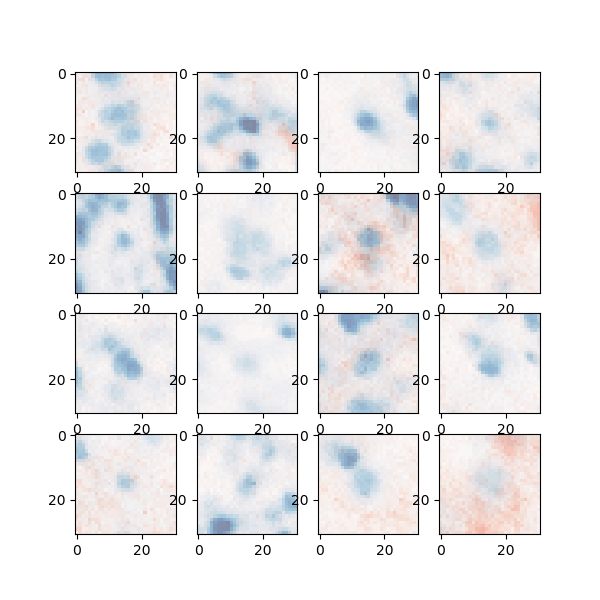

In [12]:
width = 31
n = 16

patches = random_patches([syto_slice, pv_slice], centroids, width, n)

plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches):
    plt.subplot(4, 4, i+1)
    plt.imshow(patch[0], clim=[0, 5000], cmap='Blues')
    plt.imshow(patch[1], clim=[0, 1200], cmap='Reds', alpha=0.5)
plt.show()

In [129]:
def preprocess_patch(img, max_val=None):
    if max_val is None:
        max_val = img.max()
    img = (img / max_val * 255).astype(np.uint8)
    img = resize(img, (299, 299), preserve_range=True) 
    img_rgb = np.zeros((1, *img.shape, 3), np.uint8)
    img_rgb[..., 0] = img
    img_rgb[..., 1] = img
    img_rgb[..., 2] = img
    return preprocess_input(img_rgb)

In [130]:
def make_features(output):
    aves = output.mean(axis=(1, 2))
    stds = output.std(axis=(1, 2))
    features = np.concatenate((aves, stds), axis=-1)
    return features

In [131]:
def patch_features(img, centroids, width, model):
    max_val = img.max()
    nb_patches = centroids.shape[0]
    features = np.zeros((nb_patches, 4096))
    for i, (y, x) in tqdm(enumerate(centroids), total=nb_patches):
        patch = extract_patch(img, y, x, width)
        x = preprocess_patch(patch, max_val)
        y = model.predict(x)
        features[i] = make_features(y)
    return features

In [259]:
def patch_mfi(img, centroids, width):
    max_val = img.max()
    nb_patches = centroids.shape[0]
    features = np.zeros((nb_patches, 2))
    for i, (y, x) in tqdm(enumerate(centroids), total=nb_patches):
        patch = extract_patch(img, y, x, width)
        features[i] = np.array([patch.mean(), patch.std()])
    return features

In [16]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [17]:
width = 31

syto_features = patch_features(syto_slice, centroids, width, base_model)

/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [18]:
syto_feat_path = 'syto16_features.npy'

np.save(os.path.join(working_dir, syto_feat_path), syto_features)

In [132]:
pv_features = patch_features(pv_slice, centroids, width, base_model)

/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [20]:
pv_feat_path = 'pv_features.npy'

np.save(os.path.join(working_dir, pv_feat_path), pv_features)

In [260]:
syto_mfi = patch_mfi(syto_slice, centroids, width)
pv_mfi = patch_mfi(pv_slice, centroids, width)
pv_mfi.shape

(43893, 2)

<IPython.core.display.Javascript object>


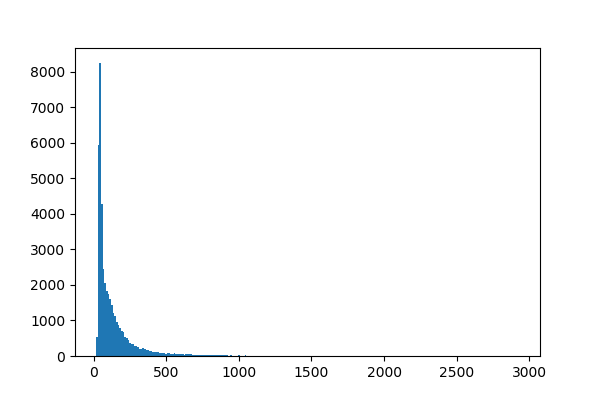

In [270]:
plt.figure(figsize=(6,4))
plt.hist(pv_mfi[:, 0], bins=256)
plt.show()

In [21]:
from sklearn.decomposition import PCA

In [21]:
syto_pca = PCA(n_components=8).fit_transform(syto_features)
syto_pca.shape

(43893, 8)

In [271]:
idx = np.where(pv_mfi[:, 0] > 100)
pv_pca = PCA(n_components=8).fit_transform(pv_features[idx])
pv_pca.shape

(18057, 8)

<IPython.core.display.Javascript object>


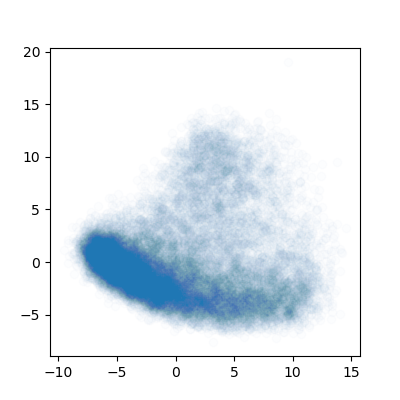

In [273]:
plt.figure(figsize=(4, 4))
plt.scatter(pv_pca[:, 0], pv_pca[:, 1], alpha=0.01)
plt.show()

<IPython.core.display.Javascript object>


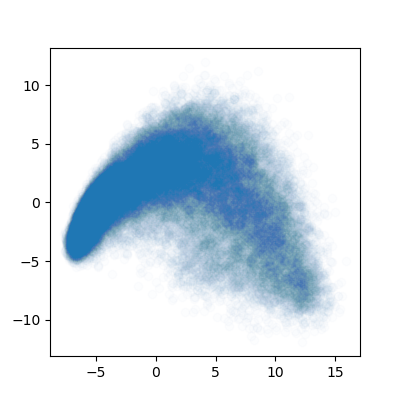

In [142]:
plt.figure(figsize=(4, 4))
plt.scatter(pv_pca[:, 0], pv_pca[:, 1], alpha=0.01)
plt.show()

In [33]:
features = np.concatenate((syto_pca, pv_pca), axis=-1)
features.shape

(43893, 16)

In [42]:
from sklearn.mixture import GaussianMixture

In [248]:
n_components = 5

gmm = GaussianMixture(n_components=n_components).fit(pv_pca)
labels = gmm.predict(pv_pca)

In [249]:
c = []
for i in range(n_components):
    c.append(pv_pca[np.where(labels==i)[0]])

<IPython.core.display.Javascript object>


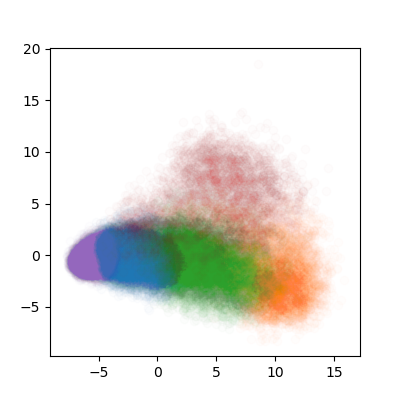

Cluster 0 contains 11076 cells (25.2%)
Cluster 1 contains 5185 cells (11.8%)
Cluster 2 contains 8710 cells (19.8%)
Cluster 3 contains 3877 cells (8.8%)
Cluster 4 contains 15045 cells (34.3%)


In [250]:
plt.figure(figsize=(4,4))
for i in range(n_components):
    n = len(c[i])
    print(f'Cluster {i} contains {n} cells ({n/nb_lbls*100:2.1f}%)')
    plt.scatter(c[i][:, 0], c[i][:, 2], alpha=0.01)
plt.show()

In [251]:
n = 16
width = 19

patches = []
for i in range(n_components):
    idx = np.where(labels==i)[0]
    patches.append(random_patches([syto_slice, pv_slice], centroids[idx], width, n))

<IPython.core.display.Javascript object>


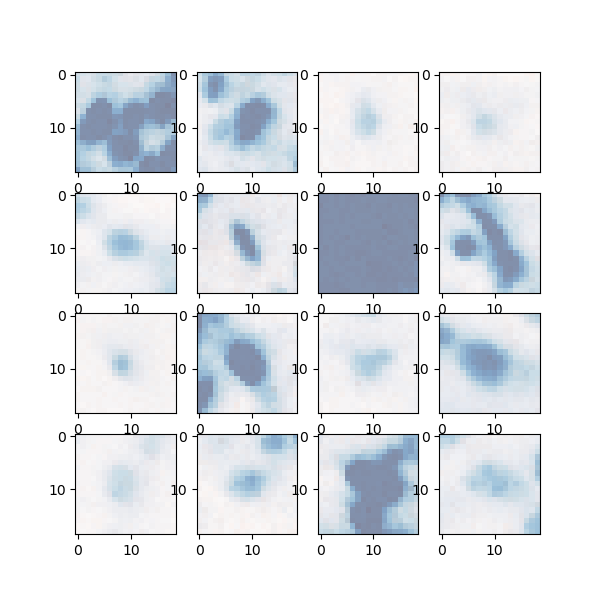

In [258]:
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches[4]):
    plt.subplot(4, 4, i+1)
    plt.imshow(patch[0], clim=[0, 5000], cmap='Blues')
    plt.imshow(patch[1], clim=[0, 2000], cmap='Reds', alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


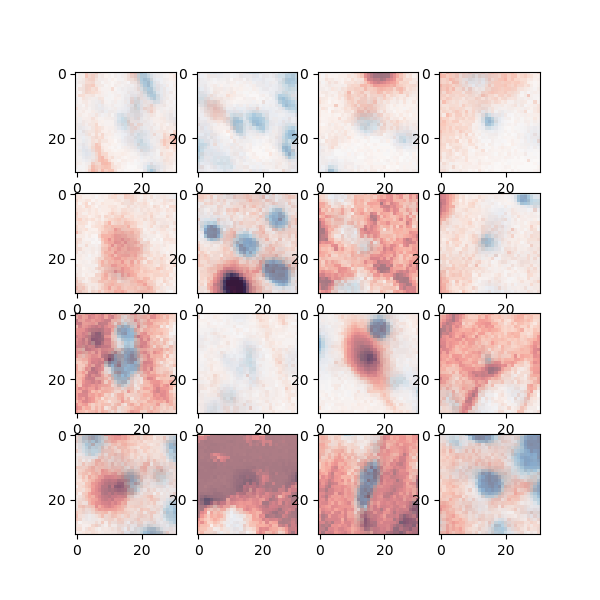

In [109]:
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches[1]):
    plt.subplot(4, 4, i+1)
    plt.imshow(patch[0], clim=[0, 5000], cmap='Blues')
    plt.imshow(patch[1], clim=[0, 1200], cmap='Reds', alpha=0.5)
plt.show()